In [4]:
import numpy
import tqdm
import wendy
%pylab inline
import matplotlib.animation as animation
from matplotlib import cm
from IPython.display import HTML
_SAVE_GIFS= False
rcParams.update({'axes.labelsize': 17.,
              'font.size': 12.,
              'legend.fontsize': 17.,
              'xtick.labelsize':15.,
              'ytick.labelsize':15.,
              'text.usetex': _SAVE_GIFS,
              'figure.figsize': [10,10],
              'xtick.major.size' : 4,
              'ytick.major.size' : 4,
              'xtick.minor.size' : 2,
              'ytick.minor.size' : 2,
              'legend.numpoints':1})
numpy.random.seed(2)


import galpy
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014
from galpy.potential import HernquistPotential
import galpy.potential as pot

Populating the interactive namespace from numpy and matplotlib


## Create a sample orbit for an external satellite (using GalPy)

[ 0.    0.01  0.02 ...  9.98  9.99 10.  ]
-20.0
0.6000865204766965 -53.10984534279593 -3.620358076082972
59.46493546156748 16.375095892808513 -3.575234462736432
-0.008264462809581355


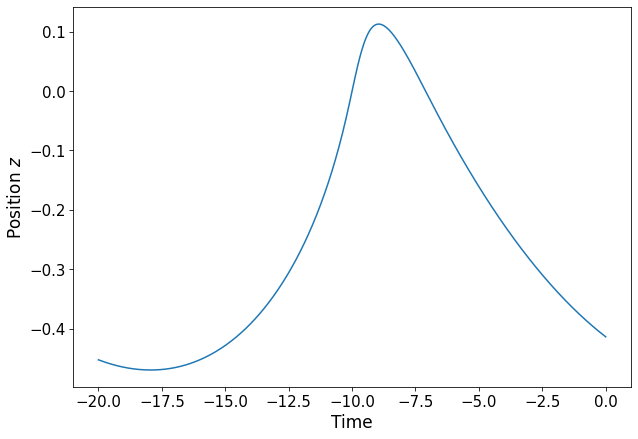

In [36]:
Jo= Orbit([1.2,-.7,1.5,0.,0.2,0.])
dt= 10
times= np.linspace(0.,dt,1001)
print(times)
Jo.integrate(times,MWPotential2014)

# print(Jo.size)
Jo= Jo(times[-1])
# print(Jo)
Jo.flip()
times= np.linspace(0,-2*dt,1001)
Jo.integrate(times,MWPotential2014)


print(times[-1])
print(Jo.x(times[-1])*8.,Jo.y(times[-1])*8.,Jo.z(times[-1])*8.)
print(Jo.vx(times[-1])*220.,Jo.vy(times[-1])*220.,Jo.vz(times[-1])*220.)


plt.figure()
plt.plot(times, Jo.z(times))
plt.xlabel("Time")
plt.ylabel(r"Position $\it{z}$")


hp= HernquistPotential(amp=2., a=1.)

def extF(x, t):
    z = abs(Jo.z(t)-x)
    return hp.zforce(0, z)

print(extF(10,-10))

## Use Wendy to solve N-body problem for a partially self-gravitating, $\mathrm{sech}^2$ disc in order to introduce spiral behavior

### Approximate solution for perturbed disc

#### We're adding in an external force that is a combination of the force from our sample satellite orbit and the force from a static, external potential (given by tot_force below)

In [37]:
N= 5000
# compute zh based on sigma and totmass
totmass= 1. # Sigma above
sigma= 1.
zh= sigma**2./totmass # twopiG = 1. in our units
tdyn= zh/sigma
x= numpy.arctanh(2.*numpy.random.uniform(size=N)-1)*zh*2.
v= numpy.random.normal(size=N)*sigma
v-= numpy.mean(v) # stabilize
m= numpy.ones_like(x)/N 

We then assign only $\alpha$ of that disk to be self-gravitating and define the external force:

In [38]:
alpha = 0.3 # "live" fraction
# Adjust masses to only represent alpha of the mass
m*= alpha
# 1-alpha in the mass is then given by the external force
sigma2= sigma**2.
def tot_force(x,t):
    return extF(x, t)-(1.-alpha)*sigma2*numpy.tanh(0.5*x/zh)/zh

In [39]:
f= wendy.nbody(x, v, m, 0.01*tdyn, approx=True, nleap=10, t0=-2.*dt, ext_force=tot_force)
# f= wendy.nbody(x, v, m, 0.01*tdyn, approx=True, nleap=10, t0=-2.*dt, ext_force=extF)
# f= wendy.nbody(x, v, m, 0.01*tdyn, nleap=10)

In [40]:
nt= 1001
xt= numpy.empty((N,nt+1))
vt= numpy.empty((N,nt+1))
Et= numpy.empty((nt+1))
xt[:,0]= x
vt[:,0]= v
Et[0]= wendy.energy(x,v,m)
for ii in tqdm.trange(nt):
    tx,tv= next(f)
    xt[:,ii+1]= tx
    vt[:,ii+1]= tv
    Et[ii+1]= wendy.energy(tx,tv,m)

100%|██████████| 1001/1001 [00:06<00:00, 150.65it/s]


Text(0, 0.5, '$E_{\\mathrm{tot}}$')

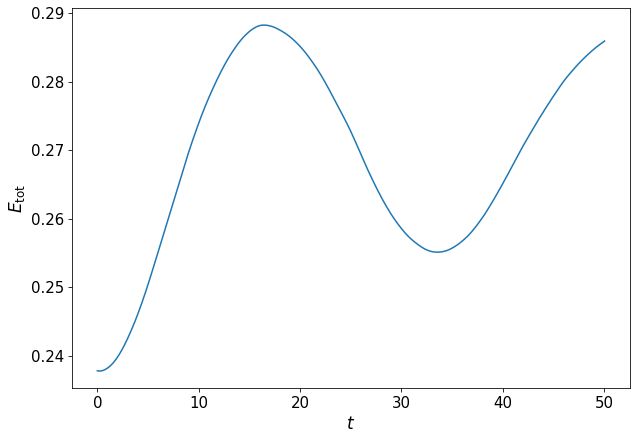

In [41]:
plot(numpy.arange(len(Et))/20.,Et)
xlabel(r'$t$')
ylabel(r'$E_{\mathrm{tot}}$')

#### Evolution of the system in phase space (color-coding is the initial energy, higher energy particles are also displayed as larger dots):

In [42]:
def init_anim_frame():
    line1= plot([],[])
    xlabel(r'$x$')
    ylabel(r'$v$')
    xlim(-7.99,7.99)
    ylim(-3.99,3.99)
    return (line1[0],)
figsize(9,6)
fig, ax= subplots()
c= wendy.energy(x,v,m,individual=True)
s= 5.*((c-numpy.amin(c))/(numpy.amax(c)-numpy.amin(c))*2.+1.)
line= ax.scatter(x,v,c=c,s=s,edgecolors='None',cmap=cm.jet)
txt= ax.annotate(r'$t=%.0f$' % (0.),
                 (0.95,0.95),xycoords='axes fraction',
                 horizontalalignment='right',verticalalignment='top',size=18.)
subsamp= 4
def animate(ii):
    line.set_offsets(numpy.array([xt[:,ii*subsamp],vt[:,ii*subsamp]]).T)
    txt.set_text(r'$t=%.0f$' % (ii*subsamp/20.))
    return (line,)
anim = animation.FuncAnimation(fig,animate,init_func=init_anim_frame,
                               frames=nt//subsamp,interval=40,blit=True,repeat=True)
if True:
    anim.save('sech2disk_alpha0.3.gif',writer='imagemagick',dpi=80)
# The following is necessary to just get the movie, and not an additional initial frame
plt.close()
out= HTML(anim.to_html5_video())
plt.close()
out

#### The density shifts

In [43]:
figsize(10,7)
fig, ax= subplots()
ii= 0
a= ax.hist(xt[:,ii],bins=31,histtype='step',lw=1.,color='k',range=[-8.,8.],weights=31./16./N*numpy.ones(N))
xs= numpy.linspace(-8.,8.,101)
ax.plot(xs,totmass/4./zh/numpy.cosh(xs/2./zh)**2.,'b--',lw=2.,zorder=0)
ax.set_xlim(-8.,8.)
ax.set_ylim(10.**-3.,1.)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$\rho(x)$')
ax.set_yscale('log')
ax.annotate(r'$t=0$',(0.95,0.95),xycoords='axes fraction',
             horizontalalignment='right',verticalalignment='top',size=18.)
subsamp= 4
def animate(ii):
    ax.clear()
    a= ax.hist(xt[:,ii*subsamp],bins=31,histtype='step',lw=1.,color='k',range=[-8.,8.],weights=31./16./N*numpy.ones(N))
    xs= numpy.linspace(-8.,8.,101)
    ax.plot(xs,totmass/4./zh/numpy.cosh(xs/2./zh)**2.,'b--',lw=2.,zorder=0)
    ax.set_xlim(-8.,8.)
    ax.set_ylim(10.**-3.,1.)
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$\rho(x)$')
    ax.set_yscale('log')
    ax.annotate(r'$t=%.0f$' % (ii*subsamp/20.),
                (0.95,0.95),xycoords='axes fraction',
                horizontalalignment='right',verticalalignment='top',size=18.)
    return a[2]
anim = animation.FuncAnimation(fig,animate,#init_func=init_anim_frame,
                               frames=nt//subsamp,interval=40,blit=True,repeat=True)
if True:
    anim.save('sech2disk_density_alpha0.3.gif',writer='imagemagick',dpi=80)
# The following is necessary to just get the movie, and not an additional initial frame
plt.close()
out= HTML(anim.to_html5_video())
plt.close()
out

#### The orbital structure in phase-space is nicely stratified in energy (color-coding indicates the initial energy) but also shifts a little due to the perturbation:

(-10.0, 10.0)

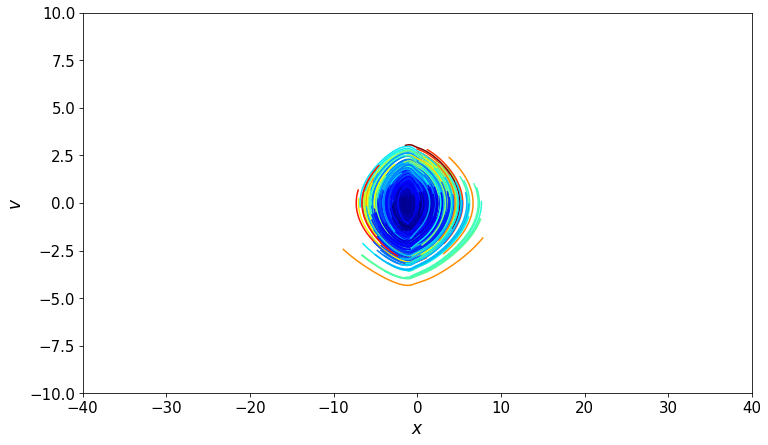

In [70]:
# figsize(12,7)
# for ii in range(N):
#     plot(xt[ii],vt[ii],'-',color=cm.jet((c[ii]-numpy.amin(c))/(numpy.amax(c)-numpy.amin(c))))
# xlabel(r'$x$')
# ylabel(r'$v$')
# xlim(-40,40)
# ylim(-10,10)

#### The velocity distribution deviates from the Gaussian distribution (shown in blue):

In [15]:
figsize(10,7)
fig, ax= subplots()
ii= 0
a= ax.hist(vt[:,ii],bins=31,histtype='step',lw=1.,color='k',range=[-4.,4.],weights=31./8./N*numpy.ones(N))
xs= numpy.linspace(-4.,4.,101)
ax.plot(xs,numpy.exp(-0.5*xs**2./sigma**2.)/numpy.sqrt(2.*numpy.pi)/sigma,'b--',lw=2.,zorder=0)
ax.set_xlim(-4.,4.)
ax.set_ylim(10.**-3.,1.)
ax.set_xlabel(r'$v$')
ax.set_ylabel(r'$f(v)$')
ax.set_yscale('log')
ax.annotate(r'$t=0$',(0.95,0.95),xycoords='axes fraction',
             horizontalalignment='right',verticalalignment='top',size=18.)
subsamp= 4
def animate(ii):
    ax.clear()
    a= ax.hist(vt[:,ii*subsamp],bins=31,histtype='step',lw=1.,color='k',range=[-4.,4.],weights=31./8./N*numpy.ones(N))
    xs= numpy.linspace(-4.,4.,101)
    ax.plot(xs,numpy.exp(-0.5*xs**2./sigma**2.)/numpy.sqrt(2.*numpy.pi)/sigma,'b--',lw=2.,zorder=0)
    ax.set_xlim(-4.,4.)
    ax.set_ylim(10.**-3.,1.)
    ax.set_xlabel(r'$v$')
    ax.set_ylabel(r'$f(v)$')
    ax.set_yscale('log')
    ax.annotate(r'$t=%.0f$' % (ii*subsamp/20.),
                (0.95,0.95),xycoords='axes fraction',
                horizontalalignment='right',verticalalignment='top',size=18.)
    return a[2]
anim = animation.FuncAnimation(fig,animate,#init_func=init_anim_frame,
                               frames=nt//subsamp,interval=40,blit=True,repeat=True)
# The following is necessary to just get the movie, and not an additional initial frame
plt.close()
out= HTML(anim.to_html5_video())
plt.close()
out

## Density Profile Datasets with Varying Perturbation Parameter & Partially Self-Gravitating Disc

### TRAIN DATA

In [ ]:
train_size = 2000
N = 1001
nt = 500
n_bins = 60
alpha= 0.3 # "live" fraction
x_min = -15.
x_max = 15.
x_range = x_max - x_min
v_min = -5.
v_max = 5.
v_range = v_max - v_min

# density array is created with dimensions:
# (input & output states (0 or 1), x or v (0 or 1), training data size, num. bins + pert param)
train_density = numpy.empty((2, 2, train_size, n_bins+1))
train_density[1, :, :, -1] = 0
energy = numpy.empty((train_size, nt+1))

count=0
for j in trange(train_size, desc='Training data progress'):
    # (input & output states, phase space degrees of freedom (x & v), no. of slabs)
    train = numpy.empty((2, 2, N))
    numpy.random.seed(j+2000)

    if j % 100 == 0:
        amp = 0.01*(count)
        hp = HernquistPotential(amp=amp, a=1.)
        count += 30
    train_density[0, :, j, -1] = amp
    def extF(x, t):
        z = abs(Jo.z(t)-x)
        return hp.zforce(0., z)


    # compute zh based on sigma and totmass
    totmass= 1. # Sigma above
    sigma= 1.
    zh= sigma**2./totmass # twopiG = 1. in our units
    tdyn= zh/sigma
    x= numpy.arctanh(2.*numpy.random.uniform(size=N)-1)*zh*2.
    v= numpy.random.normal(size=N)*sigma
    v-= numpy.mean(v) # stabilize
    m= numpy.ones_like(x)/N#*(1.+0.1*(2.*numpy.random.uniform(size=N)-1))
    

    # Adjust masses to only represent alpha of the mass
    m*= alpha
    # 1-alpha in the mass is then given by the external force
    sigma2= sigma**2.
    def tot_force(x,t):
        return extF(x, t)-(1.-alpha)*sigma2*numpy.tanh(0.5*x/zh)/zh

    
    g= wendy.nbody(x, v, m, 0.01*tdyn, approx=True, nleap=10, t0=-2.*dt, ext_force=tot_force)b
    
    train[0, 0, :]= x
    train[0, 1, :]= v
    energy[j, 0]= wendy.energy(x,v,m)
    
    for ii in arange(nt):
        tx,tv = next(g)
        energy[j, ii+1]= wendy.energy(tx,tv,m)
        
    train[1, 0, :]= tx
    train[1, 1, :]= tv
    
    
    initial_xdensity, bins = np.histogram(train[0, 0, :], bins = n_bins, range=[x_min, x_max])
    final_xdensity, bins = np.histogram(train[1, 0, :], bins = n_bins, range=[x_min, x_max])
    train_density[0, 0, j, :-1] =  initial_xdensity
    train_density[1, 0, j, :-1] =  final_xdensity

    initial_vdensity, bins = np.histogram(train[0, 1, :], bins = n_bins, range=[v_min, v_max])
    final_vdensity, bins = np.histogram(train[1, 1, :], bins = n_bins, range=[v_min, v_max])
    train_density[0, 1, j, :-1] =  initial_vdensity
    train_density[1, 1, j, :-1] =  final_vdensity
    

### TEST DATA

In [145]:
test_size = 10
N = 1001
nt = 500
n_bins = 60
alpha= 0.3 # "live" fraction
x_min = -15.
x_max = 15.
x_range = x_max - x_min
v_min = -5.
v_max = 5.
v_range = v_max - v_min

# density array is created with dimensions:
# (input & output states (0 or 1), x or v (0 or 1) testing data size, num. bins + pert param)
test_density = numpy.empty((2, 2, test_size, n_bins+1))
test_density[1, :, :, -1] = 0
energy = numpy.empty((test_size, nt+1))

count=0
for j in tqdm.trange(test_size, desc='Testing data progress'):
    # (input & output states, phase space degrees of freedom (x & v), no. of slabs)
    test = numpy.empty((2, 2, N))
    numpy.random.seed(j+2000)

    
#     if j % 100 == 0:
    amp = 0.01*(count)
    hp = HernquistPotential(amp=amp, a=1.)
    count += 50
    test_density[0, :, j, -1] = amp
    def extF(x, t):
        z = abs(Jo.z(t)-x)
        return hp.zforce(0., z)


    # compute zh based on sigma and totmass
    totmass= 1. # Sigma above
    sigma= 1.
    zh= sigma**2./totmass # twopiG = 1. in our units
    tdyn= zh/sigma
    x= numpy.arctanh(2.*numpy.random.uniform(size=N)-1)*zh*2.
    v= numpy.random.normal(size=N)*sigma
    v-= numpy.mean(v) # stabilize
    m= numpy.ones_like(x)/N#*(1.+0.1*(2.*numpy.random.uniform(size=N)-1))
    

    # Adjust masses to only represent alpha of the mass
    m*= alpha
    # 1-alpha in the mass is then given by the external force
    sigma2= sigma**2.
    def tot_force(x,t):
        return extF(x, t)-(1.-alpha)*sigma2*numpy.tanh(0.5*x/zh)/zh

    
    g= wendy.nbody(x, v, m, 0.01*tdyn, approx=True, nleap=10, t0=-2.*dt, ext_force=tot_force)
    
    test[0, 0, :]= x
    test[0, 1, :]= v
    energy[j, 0]= wendy.energy(x,v,m)
    
    for ii in arange(nt):
        tx,tv = next(g)
        energy[j, ii+1]= wendy.energy(tx,tv,m)
        
    test[1, 0, :]= tx
    test[1, 1, :]= tv
    
    
    initial_xdensity, bins = np.histogram(test[0, 0, :], bins = n_bins, range=[x_min, x_max])
    final_xdensity, bins = np.histogram(test[1, 0, :], bins = n_bins, range=[x_min, x_max])
    test_density[0, 0, j, :-1] =  initial_xdensity
    test_density[1, 0, j, :-1] =  final_xdensity

    initial_vdensity, bins = np.histogram(test[0, 1, :], bins = n_bins, range=[v_min, v_max])
    final_vdensity, bins = np.histogram(test[1, 1, :], bins = n_bins, range=[v_min, v_max])
    test_density[0, 1, j, :-1] =  initial_vdensity
    test_density[1, 1, j, :-1] =  final_vdensity
    

Testing data progress: 100%|██████████| 10/10 [00:33<00:00,  3.32s/it]


In [146]:
np.save('/Users/JawanHaider/Desktop/Research/1500/Code/Data/varpert_spiralsech2_rho_test_10xv', test_density)

# Fully Connected Feedforward Neural Network

### STEP 1: LOADING DATASET

In [147]:
'''
STEP 1: LOADING DATASET
'''

N = 1001
xv = 0
x_min = -15.
x_max = 15.
x_range = x_max - x_min
v_min = -5.
v_max = 5.
v_range = v_max - v_min


train_array = np.load('/Users/JawanHaider/Desktop/Research/1500/Code/Data/varpert_spiralsech2_rho_train_2000xv.npy')

train_in_mean = np.transpose(train_array[0, :, :, :-1].mean(axis=2))
mean_sub = np.transpose(train_array[0, :, :, :-1]) - train_in_mean
train_in_var = np.transpose(train_array[0, :, :, :-1].std(axis=2))
train_array[0, :, :, :-1] = np.transpose(mean_sub/   train_in_var    )

train_out_mean = np.transpose(train_array[1, :, :, :-1].mean(axis=2))
mean_sub = np.transpose(train_array[1, :, :, :-1]) - train_out_mean
train_out_var = np.transpose(train_array[1, :, :, :-1].std(axis=2))
train_array[1, :, :, :-1] = np.transpose(mean_sub/   train_out_var    )

train_array = np.swapaxes(train_array, 1, 2)
train_tensor = torch.Tensor(train_array)
train_dataset = TensorDataset(train_tensor[0, :, :, :], train_tensor[1, :, :, :-1]) # create your datset



test_array = np.load('/Users/JawanHaider/Desktop/Research/1500/Code/Data/varpert_spiralsech2_rho_test_10xv.npy')

test_in_mean = np.transpose(test_array[0, :, :, :-1].mean(axis=2))
mean_sub = np.transpose(test_array[0, :, :, :-1]) - test_in_mean
test_in_var = np.transpose(test_array[0, :, :, :-1].std(axis=2))
test_array[0, :, :, :-1] = np.transpose(mean_sub/   test_in_var    )

test_out_mean = np.transpose(test_array[1, :, :, :-1].mean(axis=2))
mean_sub = np.transpose(test_array[1, :, :, :-1]) - test_out_mean
test_out_var = np.transpose(test_array[1, :, :, :-1].std(axis=2))
test_array[1, :, :, :-1] = np.transpose(mean_sub/   test_out_var    )

test_array = np.swapaxes(test_array, 1, 2)
test_tensor = torch.Tensor(test_array)
test_dataset = TensorDataset(test_tensor[0, :, :, :], test_tensor[1, :, :, :-1]) # create your datset



deg_freedom = train_tensor[0, 0, :, 0].size()[0]
train_size = train_tensor[0, :, 0, 0].size()[0]
test_size = test_tensor[0, :, 0, 0].size()[0]
num_datapoints = train_tensor[0, 0, 0, :].size()[0]-1
train_amp = np.unique(train_array[0, :, 0, -1])


print(deg_freedom, train_size, test_size, num_datapoints)
print(train_amp.size)
# tst = np.transpose( np.transpose(train_array[0, :, :, :])*np.transpose(train_in_var)+np.transpose(train_in_mean) )
# print(tst.shape)
# print(tst[999, 1, :])

2 2000 10 60
20


### STEP 2: MAKING DATASET ITERABLE

In [1]:
'''
STEP 2: MAKING DATASET ITERABLE
'''

batch_size = 100
num_batches = train_size/batch_size
print(num_batches)

n_iters = 10000

num_epochs = n_iters / num_batches
print(num_epochs)
num_epochs = int(num_epochs)

train_loader = DataLoader(dataset=train_dataset, 
                            batch_size=batch_size, 
                            shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                            batch_size=batch_size, 
                            shuffle=False)

NameError: name 'train_size' is not defined

### STEP 3: CREATING MODEL CLASS

In [29]:
'''
STEP 3: CREATE MODEL CLASS
'''

class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        # Linear function 1: 784 --> 100
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        # Non-linearity 1
        self.relu1 = nn.Tanh()
        
        # Linear function 2: 100 --> 100
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # Non-linearity 2
        self.relu2 = nn.Tanh()

        # Linear function 3: 100 --> 100
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        # Non-linearity 3
        self.relu3 = nn.Tanh()

        # Linear function 4: 100 --> 100
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        # Non-linearity 4
        self.relu4 = nn.Tanh()
        
        # Linear function 5 (readout): 100 --> 10
        self.fc5 = nn.Linear(hidden_dim, output_dim)  
    
    def forward(self, x):
        # Linear function 1
        out = self.fc1(x)
        # Non-linearity 1
        out = self.relu1(out)
        
        # Linear function 2
        out = self.fc2(out)
        # Non-linearity 2
        out = self.relu2(out)
        
        # Linear function 3
        out = self.fc3(out)
        # Non-linearity 3
        out = self.relu3(out)

        # Linear function 4
        out = self.fc4(out)
        # Non-linearity 4
        out = self.relu4(out)
        
        # Linear function 5 (readout)
        out = self.fc5(out)

        return out

### STEP 4: INSTANTIATING MODEL CLASS

In [34]:
'''
STEP 4: INSTANTIATE MODEL CLASS
'''

input_dim = 2*num_datapoints+1
hidden_dim = input_dim*10
output_dim = input_dim-1
print(input_dim, hidden_dim, output_dim)

model = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim)

121 1210 120


### STEP 5: INSTANTIATING LOSS CLASS

In [35]:
'''
STEP 5: INSTANTIATE LOSS CLASS
'''

criterion = nn.MSELoss()

### STEP 6: INSTANTIATING OPTIMIZER CLASS

In [36]:
'''
STEP 6: INSTANTIATE OPTIMIZER CLASS
'''

learning_rate = 0.1

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

### STEP 7: TRAINING THE MODEL

In [37]:
'''
STEP 7: TRAIN THE MODEL
'''

iter = 0
train_predictions = np.empty((2, output_dim))
# all_true_outputs = np.empty((0, output_dim))
# all_model_outputs = np.empty((0, output_dim))

for epoch in range(num_epochs):
    # print("Epoch:", epoch)
    for i, (inputs, true_outputs) in enumerate(train_loader):
        # print("i:", i)
        
        inputs = Variable(inputs.view(-1, input_dim+1))
        temp = inputs.detach().numpy()
        temp = np.delete(temp, 60, axis=1)
        inputs = torch.tensor(temp)
        inputs = Variable(inputs)

        true_outputs = Variable(true_outputs.view(-1, output_dim))
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        model_outputs = model(inputs)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(model_outputs, true_outputs)
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
        iter += 1
        
        if iter % 2000 == 0:


            # Calculate Train Accuracy         
            correct = 0
            total = 0
            # Iterate through train dataset
            for inputs, true_outputs in train_loader:
                inputs = Variable(inputs.view(-1, input_dim+1))
                temp = inputs.detach().numpy()
                temp = np.delete(temp, 60, axis=1)
                inputs = torch.tensor(temp)
                inputs = Variable(inputs)

                true_outputs = Variable(true_outputs.view(-1, output_dim))

                # Forward pass only to get logits/output
                model_outputs = model(inputs)

                # Total number of true_outputs
                total += true_outputs.nelement()

                nppredicted = model_outputs.detach().numpy()
                nptrue = true_outputs.numpy()
                size = np.size(nptrue, 0)

                for j in range(size):
                    predicted = nppredicted[j,:]
                    true = nptrue[j,:]

                    # Total correct predictions
                    correct += (np.isclose(predicted, true, rtol=0.2)).sum()
            
            train_predictions[0, :] = true
            train_predictions[1, :] = predicted

            train_accuracy = 100 * correct / total




            # Calculate Test Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for inputs, true_outputs in test_loader:
                inputs = Variable(inputs.view(-1, input_dim+1))
                temp = inputs.detach().numpy()
                temp = np.delete(temp, 60, axis=1)
                inputs = torch.tensor(temp)
                inputs = Variable(inputs)

                true_outputs = Variable(true_outputs.view(-1, output_dim))

                # Forward pass only to get logits/output
                model_outputs = model(inputs)

                # Total number of true_outputs
                total += true_outputs.nelement()

                nppredicted = model_outputs.detach().numpy()
                nptrue = true_outputs.numpy()
                size = np.size(nptrue, 0)

                for j in range(size):
                    predicted = nppredicted[j,:]
                    true = nptrue[j,:]

                    # Total correct predictions
                    correct += (np.isclose(predicted, true, rtol=0.2)).sum()
            
            test_accuracy = 100 * correct / total




            # Print Loss
            print('Iteration: {}. Loss: {}. Train Accuracy: {}. Test Accuracy: {}'.format(iter, loss.data, train_accuracy, test_accuracy))
            
    start_time = time.time()
    main()

print("--- %s seconds ---" % (time.time() - start_time))

Iteration: 2000. Loss: 0.0301356203854084. Train Accuracy: 79.31. Test Accuracy: 80.23666666666666
Iteration: 4000. Loss: 0.025010686367750168. Train Accuracy: 80.41708333333334. Test Accuracy: 81.14083333333333
Iteration: 6000. Loss: 0.023274093866348267. Train Accuracy: 80.74041666666666. Test Accuracy: 81.5425
Iteration: 8000. Loss: 0.023273292928934097. Train Accuracy: 80.84958333333333. Test Accuracy: 81.6675
Iteration: 10000. Loss: 0.022617846727371216. Train Accuracy: 81.0025. Test Accuracy: 81.68583333333333


### STEP 8: TESTING THE MODEL 

In [149]:
'''
STEP 8: TESTING THE MODEL
'''

input_array = np.empty((0, input_dim))
output_array = np.empty((0, output_dim))
target_array = np.empty((0, output_dim))

start = time.time()

iter = 0
# Iterate through test dataset
for inputs, true_outputs in test_loader:
    iter += 1
    
    inputs = Variable(inputs.view(-1, input_dim+1))
    temp = inputs.detach().numpy()
    temp = np.delete(temp, 60, axis=1)
    inputs = torch.tensor(temp)
    inputs = Variable(inputs)
    
    true_outputs = Variable(true_outputs.view(-1, output_dim))

    # Forward pass only to get logits/output
    model_outputs = model(inputs)

    loss = criterion(model_outputs, true_outputs)
    
    npinputs = inputs.detach().numpy()
    input_array = np.concatenate((input_array, npinputs))

    npoutputs = model_outputs.detach().numpy()
    output_array = np.concatenate((output_array, npoutputs))

    nptargets = true_outputs.detach().numpy()
    target_array = np.concatenate((target_array, nptargets))
    
    print('Batch: {}. Loss: {}.'.format(iter, loss.data))

end = time.time()

print(f"\nRuntime of the program is {end - start} seconds")

Batch: 1. Loss: 0.02730717323720455.

Runtime of the program is 0.010293960571289062 seconds


### STEP 9: DENORMALIZING THE DATA

In [150]:
'''
STEP 9: DENORMALIZING THE DATA
'''

target_array = np.reshape(target_array, (test_size, 2, 60))
output_array = np.reshape(output_array, (test_size, 2, 60))
amp = input_array[:, -1]
test_amp = np.unique(amp)
input_array = np.delete(input_array, -1, axis=1)
input_array = np.reshape(input_array, (test_size, 2, 60))


target_array = np.transpose(target_array) * np.transpose(test_out_var) 
target_array = np.transpose( target_array + np.transpose(test_out_mean) )
target_array[target_array < 0] = 0

output_array = np.transpose(output_array) * np.transpose(test_out_var)
output_array = np.transpose( output_array + np.transpose(test_out_mean) )
output_array[output_array < 0] = 0

input_array = np.transpose(input_array) * np.transpose(test_in_var)
input_array = np.transpose( input_array + np.transpose(test_in_mean) )
input_array[input_array < 0] = 0

### STEP 10: PLOTTING THE RESULTS

In [151]:
print(train_amp, "\n\n", test_amp)

[0.000000 0.300000 0.600000 0.900000 1.200000 1.500000 1.800000 2.100000
 2.400000 2.700000 3.000000 3.300000 3.600000 3.900000 4.200000 4.500000
 4.800000 5.100000 5.400000 5.700000] 

 [0.000000 0.500000 1.000000 1.500000 2.000000 2.500000 3.000000 3.500000
 4.000000 4.500000]


Text(0, 0.5, '$\\rho(x)$')

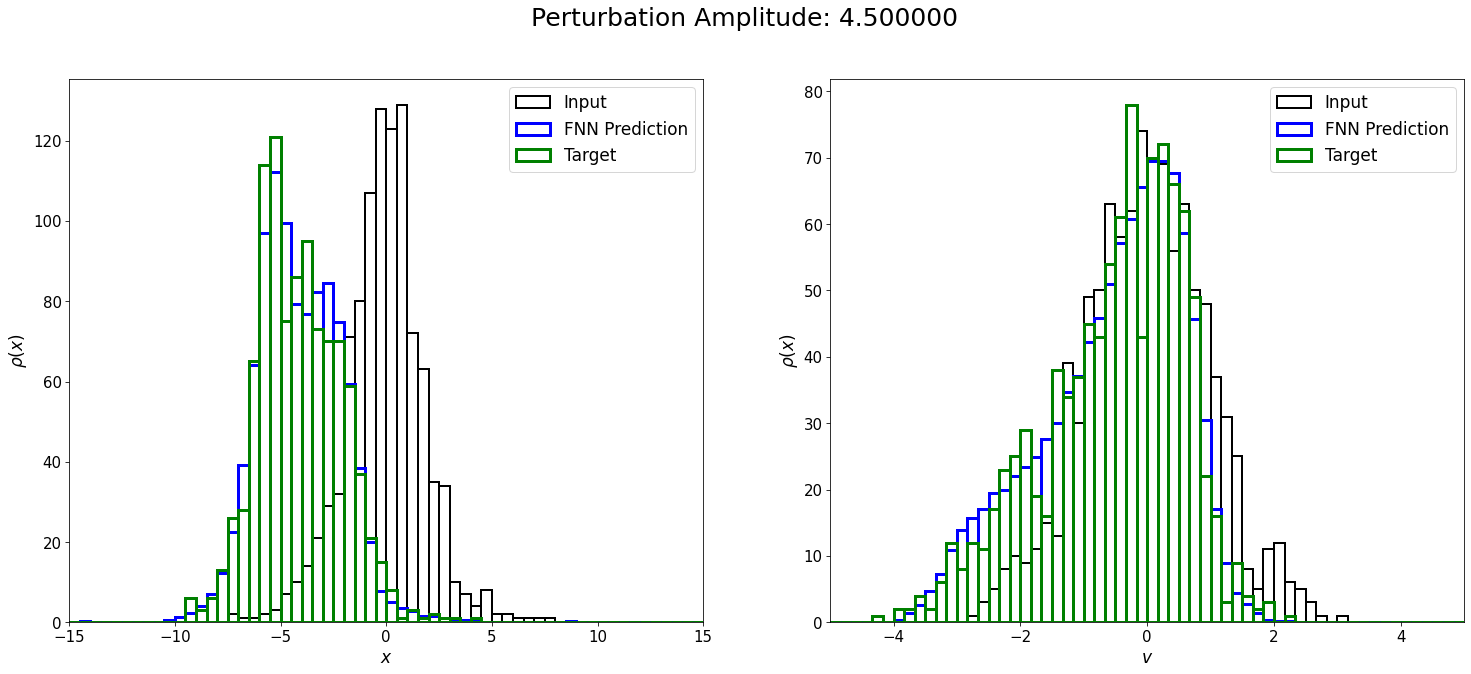

In [159]:
'''
STEP 10: PLOTTING THE RESULTS
'''

fig, (ax1, ax2) = subplots(1, 2, figsize=(25,10))

datapoint = 9
xv = 0
width = x_range/num_datapoints
bins = np.linspace(x_min, x_max, num=num_datapoints, endpoint=False)

fig.suptitle('Perturbation Amplitude: %f' %amp[datapoint], fontsize=25)

ax1.bar(bins, input_array[datapoint, xv, :], width=width, lw=2., ec='k', fill=False, align='edge', label='Input')
ax1.bar(bins, output_array[datapoint, xv, :], width=width, lw=3., ec='b', fill=False, align='edge', label='FNN Prediction')
ax1.bar(bins, target_array[datapoint, xv, :], width=width, lw=3., ec='g', fill=False, align='edge', label='Target')
ax1.legend()
ax1.set_xlim(x_min, x_max)
ax1.set_xlabel(r'$x$')
ax1.set_ylabel(r'$\rho(x)$')

xv = 1
width = v_range/num_datapoints
bins = np.linspace(v_min, v_max, num=num_datapoints, endpoint=False)

ax2.bar(bins, input_array[datapoint, xv, :], width=width, lw=2., ec='k', fill=False, align='edge', label='Input')
ax2.bar(bins, output_array[datapoint, xv, :], width=width, lw=3., ec='b', fill=False, align='edge', label='FNN Prediction')
ax2.bar(bins, target_array[datapoint, xv, :], width=width, lw=3., ec='g', fill=False, align='edge', label='Target')
ax2.legend()
ax2.set_xlim(v_min, v_max)
ax2.set_xlabel(r'$v$')
ax2.set_ylabel(r'$\rho(x)$')

### STEP 11: MEASURING PERFORMANCE

In [141]:
'''
STEP 11: MEASURING PERFORMANCE
'''

output_array_flt = output_array.flatten()
target_array_flt  = target_array.flatten()

rel_err = np.empty(test_size)

for i in range(test_size):
    if target_array_flt[i]==0 or output_array_flt[i]!=0:
        rel_err[i] = 0
    else:
        rel_err[i] = np.abs(output_array_flt[i]-target_array_flt[i])/(target_array_flt[i])

print("Relative error:", rel_err.mean()*100, "%")

# xv=1
# print(stats.kstest(output_array[200, xv, :], target_array[200, xv, :]))
# print(stats.ks_2samp(output_array[200, xv, :], target_array[200, xv, :]))

kl_div = stats.entropy( np.transpose(output_array[:, 1, :]), np.transpose(target_array[:, 1, :]) )
print(kl_div)

Relative error: 3.2 %
[inf inf 0.088298 0.104643 0.181094 0.029793 0.062590 inf 0.077702
 0.030811 0.076305 0.051460 inf inf inf 0.086591 inf 0.192299 inf 0.070007
 0.078709 inf 0.045300 0.040989 0.043680 0.024578 0.165023 inf 0.097440
 inf 0.133088 0.185988 0.042341 0.116860 inf inf inf inf 0.163470 0.259936
 inf inf inf 0.044054 inf inf inf inf 0.084943 inf inf 0.092040 0.025745
 0.119410 inf inf 0.123861 0.079199 0.119371 inf inf 0.059090 0.061073 inf
 0.111817 0.218200 0.097216 0.095095 0.135101 inf inf inf inf 0.103143
 0.076432 inf 0.172811 inf 0.041482 0.097840 inf 0.104042 inf inf inf
 0.042590 inf inf inf inf inf inf inf 0.074819 0.057115 0.039439 0.048792
 0.054722 0.074382 inf inf 0.156202 0.192528 0.055788 inf inf inf 0.070694
 0.056989 0.059053 0.163778 inf 0.178681 inf 0.025370 0.035924 0.040099
 0.147151 inf inf 0.071773 0.055342 inf 0.065866 inf 0.103138 0.056003 inf
 inf 0.019287 0.023944 0.041032 inf inf inf 0.075674 0.129932 inf inf
 0.152448 0.029465 inf inf inf inf